## Flower Classification
Flower Classification with a dataset which has a 'label' for every flower image. The images are divided into five classes: chamomile, tulip, rose, sunflower, dandelion.
For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

## Import Modules

In [283]:
import cv2 # First install your OpenCV-Python if you haven't
import os 
import numpy as np
import sklearn as sk 
import matplotlib.pyplot as plt 
from scipy.cluster.vq import kmeans, vq
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

## Loading the image data

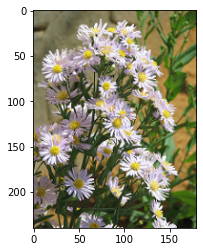

Image Size: (240, 180, 3)
 Image Data Type: <class 'numpy.ndarray'>, uint8
 Max-Min Pixel Value: 255, 0
After normalization, Max-Min Pixel Value: 1.0, 0.0


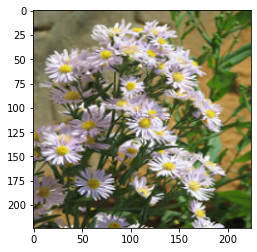

In [259]:
image_path = "./flower_train/daisy/99306615_739eb94b9e_m.jpg"
sample_image = cv2.imread(image_path) # Image will be B,G,R order.
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
plt.imshow(sample_image) # plt.imshow() will assume R, G, B order
plt.show()
print("Image Size: {}\n".format(sample_image.shape),
      "Image Data Type: {}, {}\n".format(type(sample_image), sample_image.dtype),
      "Max-Min Pixel Value: {}, {}".format(sample_image.max(), 
                                           sample_image.min()))

# Basic processing method - resize, normalization
sample_image_resize = cv2.resize(sample_image, (224, 224))
sample_image_norm_resize = sample_image_resize / 255.0
print("After normalization, Max-Min Pixel Value: {}, {}".format(sample_image_norm_resize.max(), 
                                           sample_image_norm_resize.min()))
plt.imshow(sample_image_norm_resize)
plt.show()

## Feature Extraction

For feature extraction, you can use from the most simple statistics of the image, e.g., statistic of colors, histogram of intensity/color values, to many advanced feature extractors/descriptors(shape, texture) in traditional image processing and computer vision, e.g, SIFT(scale-invariant feature transform), SURF(speeded up robust features), LESH(Local energy-based shape histogram), Gabor filters. These feature descriptors are built into Open-CV Python package, you can directly use them

### SIFT feature

In [260]:
gray = cv2.cvtColor(sample_image_resize, cv2.COLOR_RGB2GRAY)
print(gray.shape)

sift = cv2.SIFT_create(200) #limit the number of keypoints you want to constrain

kp, des = sift.detectAndCompute(gray,None)
for i in range(len(kp)):
    print(kp[i].pt, des[i])
print("Number of keypoints: {}, Feature Dimension For each keypoints: {}".format(len(kp), des[0].shape))

(224, 224)
(124.58318328857422, 160.28240966796875) [  2.   9.  20.   2.   1.  21.  88.   3.   2.  18.  50.   0.   0.   5.
 102.  18.  48.  27.  46.   0.   0.   4.  53.  50.  44.  86.  51.   2.
   1.  10.   9.   6.   7.   4.   5.  27.  41.  51.  76.   2.  98.  11.
   5.   7.   2.  13. 126.  76.  14.   1.   1.   0.   1.  40. 126.  59.
  10.  16.  12.   2.   8. 108. 126.  13.  21.  14.   7.  98. 100.   6.
   0.   0. 126.  86.   6.  11.   3.   3.   7.  14.  60.  40.  12.   6.
   3.  17.  57.  21.   7.  10.   1.   0.  37.  74.  52.  11.  15.  12.
  17.  74.  40.  13.   1.   3. 126. 126.   3.   4.   1.   0.   0.   6.
  77. 120.   4.   3.   1.   0.   0.  10.  25.  19.   1.   0.   7.  18.
  11.  13.]
(56.591529846191406, 64.5738296508789) [  1.   0.   2.   9.  10. 121.  73.   4.  57.   1.   1.   1.   2.  36.
  77. 122.  24.   0.   0.   1.  43.  60.  17.  38.   0.   0.   0.   0.
  10.  81.  59.   2.  28.  16.  27.  65.  50.  52.  16.   9. 122.  31.
  11.   7.   8.  45.  78. 122.  14.   3.   2.

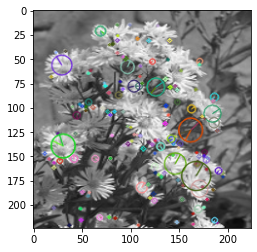

In [261]:
### visualize keypoints 
img=cv2.drawKeypoints(gray ,
                      kp ,
                      sample_image_norm_resize ,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)

### Color Histogram feature

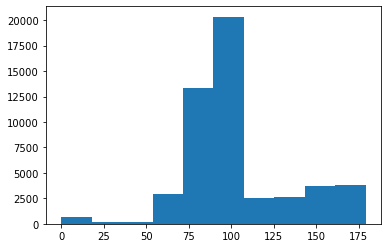

In [262]:
H = cv2.cvtColor(sample_image_resize, cv2.COLOR_BGR2HSV)[...,0]
hue_dist, bins = np.histogram(H, bins=255)
plt.hist(H.reshape((-1,)))
plt.show()

### Process the features into what you can fit into ML models
Especially for feature like SIFT, you want to reduce dimensionality since (num_keypoints, 128) is very large. First you might want to limit the number of keypoints to extract. Also, you want to reduce the dims by a method called `bag of visual words`, where you treat each 128-d vector as a visual word, and assign it a label. However, the vector space is continuous unlike the vocabularies where the representation is discrete. So in this case, what you want to do is to
discretize the 128-d space by some clustering method, e.g, KMeans, (you need to choose num_clusters yourself). After you perform clustering using all your training data of size(num_images x num_keypoints, 128), each of these vector will have a cluster label ranging from 0 - num_clusters - 1, then you can treat them as so-called 'visual word'. For each image, now your representation becomes a bag of visual words, quite similar to the representation of the document.

In [263]:
def convertImage(img):
    """
    take image as input and
    1. resize to (224, 224), 
    2. converts to gray
    and returns the gray image
    """
    sample_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    sample_image_resize = cv2.resize(sample_image, (224, 224))
    # sample_image_norm_resize = sample_image_resize / 255.0
    gray = cv2.cvtColor(sample_image_resize, cv2.COLOR_RGB2GRAY)
    return gray

In [264]:
## Load Data 
train_path = './flower_train'
# we need to escape config file. 
train_class = [folder for folder in os.listdir(train_path) if not folder.startswith('.')]

path_image = []     # list of path to the images
class_image = []    # list of classes for images
class_id = 0        # just to update class_image, allocating the id for image class  

def getlist(path):    
    return [os.path.join(path, file) for file in os.listdir(path)]
    
for _class in train_class:
    """
    get the list of images, path to images and their respective classes. 
    """
    dir = os.path.join(train_path, _class)
    class_path = getlist(dir)
    path_image += class_path
    class_image += [class_id]*len(class_path)
    class_id += 1

########################################################
# Just for surety, printing levels and corresponsing Id. 
ID = 0
for _class in train_class:
    print("Class {}: {}".format(ID,_class ))
    ID += 1

Class 0: daisy
Class 1: rose
Class 2: tulip
Class 3: dandelion
Class 4: sunflower


In [265]:
### configuration zone
k = 250  ## number of cluster in k-means 
num_keypoints = 200

In [266]:
#
# fetch each image from their path, convert, get SIFT and append the descriptor
# get vertical stack of the descriptor data.
#
list_descriptors = []  # list of descriptors 
sift = cv2.SIFT_create(num_keypoints) 

for path in path_image:
    im = cv2.imread(path)    # fetch image 
    im = convertImage(im)    # convert image 
    kps, des = sift.detectAndCompute(im, None)      # get descriptor 
    list_descriptors.append((path, des))            # get list of descriptors 

descriptors = list_descriptors[0][1]
for _, descriptor in list_descriptors[1:]:
    descriptors = np.vstack((descriptors, descriptor))  # get stack of descriptors 

descriptors_float = descriptors.astype(float)    # convert descriptors to float 

In [267]:
# clustering 
voc, _ = kmeans(descriptors_float, k, 1) 

# histogram 
im_histogram = np.zeros((len(path_image), k), "float32")
for i in range(len(path_image)):
    words, distance = vq(list_descriptors[i][1],voc)
    for word in words:
        im_histogram[i][word] += 1

## Normalization 
stdScaler_model = StandardScaler().fit(im_histogram)
im_histogram = stdScaler_model.transform(im_histogram)

## Fit into your ML models
Try a variable list of classical ML models you've learned so far in class to perform this multi-classification, i.e., 
RandomForest, Multinomial Logistic Regression(LR for multi-class scenario), and also some others classical approach
like SVM(kernel), NaiveBayes etc. Compare the models you've tried on the classification accuracy on test data, plot the confusion matrix. You can experiment on a large vareity of image features not limited to SIFT introduced here, but SIFT can be a decent baseline for you to work on. In this assignment, we do not expect you to be able to achieve high accuracy on the test result since image classification using traditional feature extraction is quited limited. When we later introduce Deep Neural Nets and especially CNN(Convolutional Neural Network), you will easily achieve a high performance. The purpose of this assignment is let you understand and explore how you can do feature engineering in image domain and let you learn some fundamentals of digital image processing.

In [268]:
## random forest classifier 
classifier = RandomForestClassifier(n_estimators = 100, random_state=43)
classifier.fit(im_histogram, np.array(class_image))

RandomForestClassifier(random_state=43)

In [296]:
## all other classifiers 
# SVM
classifier_SVC =  SVC(max_iter=10000)
classifier_SVC.fit(im_histogram, np.array(class_image))

## Multinomial Logistics regression
classifier_Logistics = LogisticRegression(multi_class= 'multinomial')
classifier_Logistics.fit(im_histogram, np.array(class_image))

# Naive Bayes 
classifier_Naive = MultinomialNB()
classifier_Naive.fit(abs(im_histogram), np.array(class_image))

# classifier_SVC, classifier_Logistics, classifier_Naive

MultinomialNB()

### On Test dataset

In [269]:
test_path = './flower_test'
test_class = [folder for folder in os.listdir(test_path) if not folder.startswith('.')]

# list declaration for collecting image path and corresponding classes
test_path_image = []  ## list of path of images
test_class_image = []  ## list of classes for images
test_class_id = 0      ### just to update class_image list 

def getlist(path):    
    return [os.path.join(path, file) for file in os.listdir(path)]
    
for _class in test_class:
    dir = os.path.join(test_path, _class)
    test_class_path = getlist(dir)
    test_path_image += class_path
    test_class_image += [test_class_id]*len(class_path)
    test_class_id += 1

In [270]:
test_descriptor_list = []

for path in path_image:
    im = cv2.imread(path)
    im = convertImage(im)
    kps, des = sift.detectAndCompute(im, None)
    test_descriptor_list.append((path, des))

descriptors = test_descriptor_list[0][1]
for image_path, descriptor in test_descriptor_list[0:]:
    descriptors = np.vstack((descriptors, descriptor)) 

### test histogram 
test_histogram = np.zeros((len(test_path_image), k), "float32")
for i in range(len(test_path_image)):
    words, distance = vq(test_descriptor_list[i][1],voc)
    for w in words:
        test_histogram[i][w] += 1

Accuracy - Random Forest: 0.699
Confusion Matrix - Random Forest:
 [[586   0   0   0   0]
 [  0 319   0   0 267]
 [ 25   0 559   0   2]
 [  0 522   0  64   0]
 [  0   0  67   0 519]]

Accuracy - SVM: 0.624
Confusion Matrix - SVM:
 [[491  27   7  11  50]
 [  3 297  13   8 265]
 [ 24  19 487   3  53]
 [  6 485   9  64  22]
 [  8   6  80   3 489]]

Accuracy - Logistic Reg: 0.484
Confusion Matrix - Logistic Reg:
 [[399  69  23  30  65]
 [ 46 260  52  33 195]
 [ 40  49 343  30 124]
 [ 36 401  23  76  50]
 [ 34  56 125  32 339]]

Accuracy - Naive Bayes: 0.378
Confusion Matrix - Naive Bayes:
 [[386  37  46  55  62]
 [ 90 178 100  88 130]
 [ 75  44 259  74 134]
 [114 259  44 110  59]
 [ 82  57 198  74 175]]



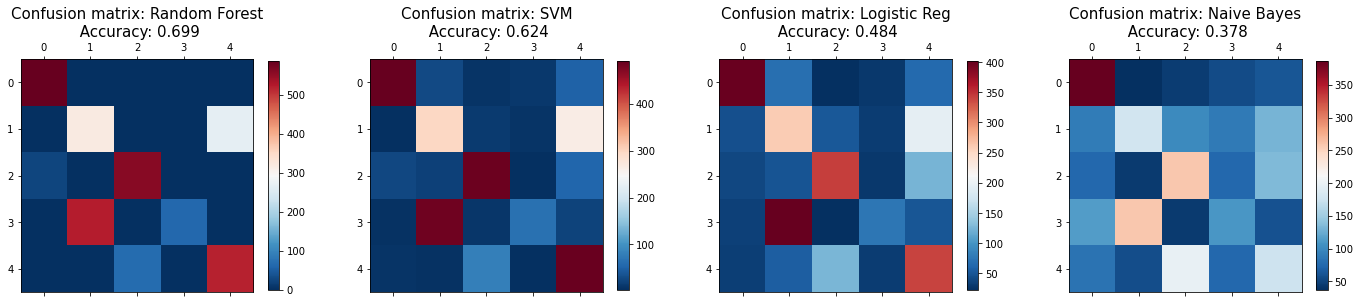

In [424]:
test_features = stdScaler_model.transform(test_histogram)
ground_truth =  [train_class[idx] for idx in test_class_image]
predictions_RF =  [train_class[i] for i in classifier.predict(test_features)]
predictions_SV =  [train_class[i] for i in classifier_SVC.predict(test_features)]
predictions_log =  [train_class[i] for i in classifier_Logistics.predict(test_features)]
predictions_NB =  [train_class[i] for i in classifier_Naive.predict(test_features)]

_dict = {}
_dict['Random Forest'] = predictions_RF 
_dict["SVM"] = predictions_SV 
_dict["Logistic Reg"] = predictions_log 
_dict["Naive Bayes"] = predictions_NB

accuracy = []
confused = []
for x in _dict:
    accuracy.append( accuracy_score(ground_truth, _dict[x]) )
    confused.append( confusion_matrix(ground_truth, _dict[x]) )

for i in range(len(accuracy)):
    print("Accuracy - {}: {}".format(list(_dict.keys())[i], round(accuracy[i], 3) ) )
    print("Confusion Matrix - {}:\n {}\n".format(list(_dict.keys())[i], confused[i] ) )


fig, axs = plt.subplots(1, 4, figsize = (24,6))
# cmaps = ['RdBu_r', 'viridis']
idx = 0
for col in range(4):
    ax = axs[col]
    a = ax.matshow(confused[idx],cmap='RdBu_r' )
    ax.set_title("Confusion matrix: {}\n Accuracy: {}".format(list(_dict.keys())[idx], round(accuracy[idx],3)), size = 15)
    fig.colorbar(a, ax=ax, use_gridspec = True, shrink = .7)
    idx += 1

plt.show()